# MCMC algorithm - fitting spectral line


In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

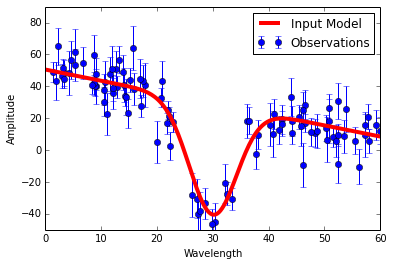

In [22]:
# We create and artificial spectral line
def get_val(x, p):
    m, b, sigma, C, lamb_0 = p
    return m*x + b - C*np.exp(-(x-lamb_0)**2 / sigma**2) 

# Input parameters of the line
m_truth = -0.7
b_truth = 50.5
lamb_0 = 30.
C = 70.
sigma = 6.
truths = m_truth, b_truth, sigma, C, lamb_0

# We will have a wavelength resolution of 1
data = np.zeros((100, 3)) # make an empty matrix with 3 columns and 100 rows
data[:,0] = np.random.uniform(1, 60, size=100)
data[:,2] = np.random.uniform(5, 15, size=100)
data[:,1] = get_val(data[:,0], truths) + np.random.normal(loc=0,scale=data[:,2],size=100)

# Plot data points
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], label='Observations', fmt='o')

# Plot Input values
x = np.linspace(0,60,200)
y = get_val(x, truths)
plt.plot(x,y, color='r', linewidth=4, label='Input Model')

plt.xlim(0,60)
plt.ylim(-50,90)
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [23]:
# Now let's define the posterior probability
def ln_prior(p):
    m, b, sigma, C, lamb_0 = p
    lp = 0.0
    return lp

def ln_likelihood(p, data):
    x_vals = data[:,0]
    y_vals = data[:,1]
    y_errs = data[:,2]
    y_model = get_val(x_vals, p)
    ll = -0.5 * np.sum(((y_vals - get_val(x_vals,p))/y_errs) ** 2)
    return ll

def ln_posterior(p,data):
    lp = ln_prior(p)
    if np.isinf(lp): return -np.inf
    ll = ln_likelihood(p, data)
    return lp+ll

In [37]:
# Now we are going to use the MCMC
nwalkers = 10
ndim = 50

# The array of initial positions
initial = np.array([0, 10.0, 5.0, 10., 1.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in xrange(nwalkers)]

# Create sampler object
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=(data,))

# Burn-in
pos,prob,state = sampler.run_mcmc(p0, N=1000)

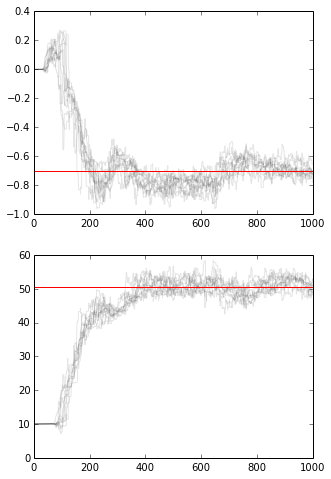

In [38]:
# Plot the trace
fig, ax = plt.subplots(2,1, figsize=(5,8))

# Plot trace
for i in range(2):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.1, color='k')

    ax[i].axhline(truths[i], color='r')
        
plt.show()


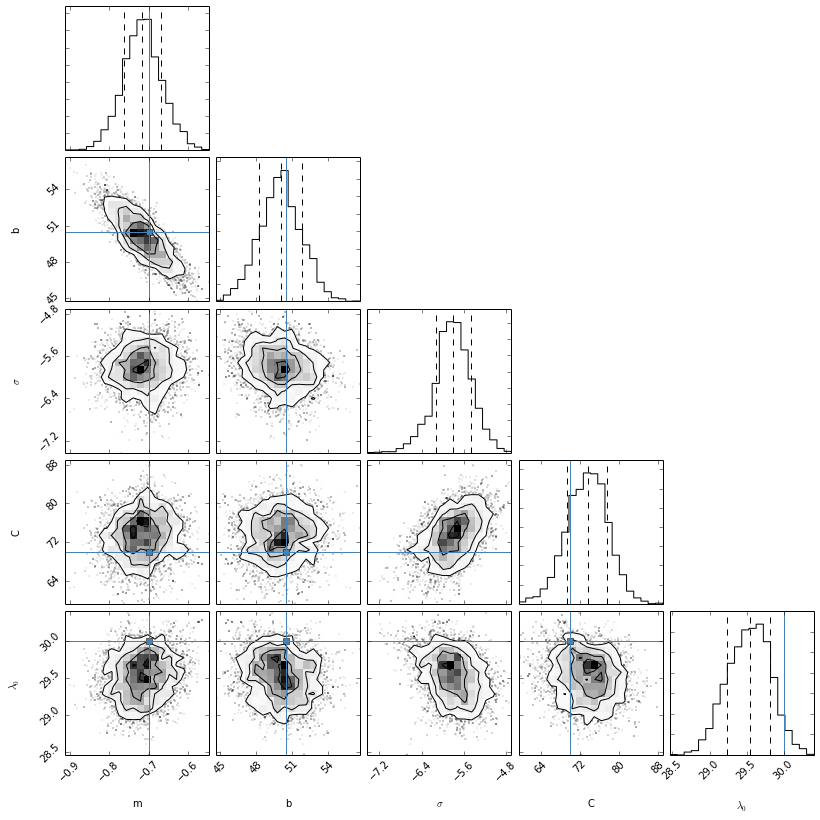

In [39]:
# Reset the sampler, restart the sampler at this current position, which we saved from before and called "pos"
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, N=1000)
corner.corner(sampler.flatchain, truths=truths,labels=["m", "b", "$\sigma$", "C","$\lambda_0$"],
             quantiles=[0.16, 0.5, 0.84])

plt.show()

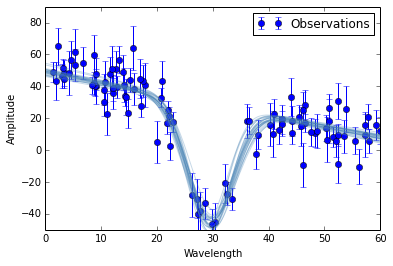

In [40]:
# Plot Input values
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], label='Observations', fmt='o')

x = np.linspace(0,60,200)
y = get_val(x, truths)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    plt.plot(x, get_val(x,s), color="#4682b4", alpha=0.3)
    
plt.xlim(0,60)
plt.ylim(-50,90)
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [41]:
# A good test of whether or not the sampling went well is to check the mean acceptance fraction of the ensemble
# This number should be between approximately 0.25 and 0.5 if everything went as planned
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.563
